# Demonstrate Seg-Grad-CAM on a vanilla U-Net trained on Cityscapes

## 0. Imports 

In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
from pathlib import Path
import sys
import matplotlib.pyplot as plt

from seggradcam.dataloaders import Cityscapes
#from metrics import iou_coef, dice_coef, dice_loss
from seggradcam.unet import csbd_unet, manual_unet, TrainUnet
from seggradcam.training_write import TrainingParameters, TrainingResults
from seggradcam.training_plots import plot_predict_and_gt, plot_loss, plot_metric
from seggradcam.seggradcam import SegGradCAM, SuperRoI, ClassRoI, PixelRoI, BiasRoI
from seggradcam.visualize_sgc import SegGradCAMplot

ModuleNotFoundError: No module named 'seggradcam'

## 1. Dataset set up

In [4]:
BATCH_SIZE = 4
trainparam = TrainingParameters(
    epochs = 2, #50,
    scale = 4,
    batch_size = BATCH_SIZE, 
    n_train= 2975, #2975 max
    n_val = 500 # 500 max 
    ,steps_per_epoch = int(3000/BATCH_SIZE)
    ,validation_steps = int(500/BATCH_SIZE)   
    )
trainparam.saveToJson()

trainset = Cityscapes(n = trainparam.n_train, shuffle = True, scale = trainparam.scale, prefix = "train",normalize=True)
valset = Cityscapes(n = trainparam.n_val, shuffle = False, scale = trainparam.scale, prefix = "val",normalize=True)

## 1.1 A. Prepare dataset

In [6]:
path = "C:\\Users\\vinograd\\Documents\\cityscapes\\leftImg8bit_trainvaltest\\leftImg8bit"
#path = "../../inputs/cityscapes/leftImg8bit_trainvaltest/leftImg8bit"
trainset.get_and_save_npz(path)
valset.get_and_save_npz(path)

Root path:  C:\Users\vinograd\Documents\cityscapes\leftImg8bit_trainvaltest\leftImg8bit\train
Length of the set: 2975 .  2975  will be loaded.


100%|██████████████████████████████████████████████████████████████████████████████| 2975/2975 [01:43<00:00, 28.61it/s]


Root path:  C:\Users\vinograd\Documents\cityscapes\leftImg8bit_trainvaltest\leftImg8bit\val
Length of the set: 500 .  500  will be loaded.


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:18<00:00, 27.35it/s]


## 1.1 B. Load prepared dataset

In [10]:
trainset.load_npz()
valset.load_npz()

## 2. U-Net

## 2.1 A. Train a U-Net yourself 

In [11]:
trainunet = TrainUnet(trainparam)
trainunet.csbdUnet()
fit_out = trainunet.fit_generator(trainset,valset)

trainingResults = TrainingResults(trainparam, fit_out)
trainingResults.modelSummaryTxt()
trainingResults.writeResultsTxt()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.




Epoch 1/2
 30/750 [>.............................] - ETA: 3:56:10 - loss: 2.2886 - acc: 0.13 - ETA: 3:32:09 - loss: 2.1912 - acc: 0.18 - ETA: 3:23:09 - loss: 2.1413 - acc: 0.23 - ETA: 3:17:08 - loss: 2.0833 - acc: 0.27 - ETA: 3:07:51 - loss: 2.0571 - acc: 0.29 - ETA: 3:07:37 - loss: 2.0467 - acc: 0.31 - ETA: 3:03:55 - loss: 2.0056 - acc: 0.33 - ETA: 3:01:29 - loss: 1.9786 - acc: 0.34 - ETA: 2:59:29 - loss: 1.9669 - acc: 0.35 - ETA: 2:58:10 - loss: 1.9433 - acc: 0.36 - ETA: 2:57:01 - loss: 1.9039 - acc: 0.38 - ETA: 2:55:19 - loss: 1.8

KeyboardInterrupt: 

### Training plots

In [ ]:
# save few predictions to the folder
str_folder = str(trainparam.outfolder)
# plot loss and other metrics
plot_loss(fit_out,  str_folder)
plot_metric(trainparam.metrics, fit_out, str_folder)

## 2.1 B. Load a U-Net 

In [13]:
trainparam.outfolder = Path('../../output/Cityscapes/07_23_03_36_fil32_depth4_lr0.0003_scale4_batch4')
trainunet = TrainUnet(trainparam)
trainunet.csbdUnet()
trainunet.compile()
trainunet.load_weights()

## 2.2. Take a look at predictions

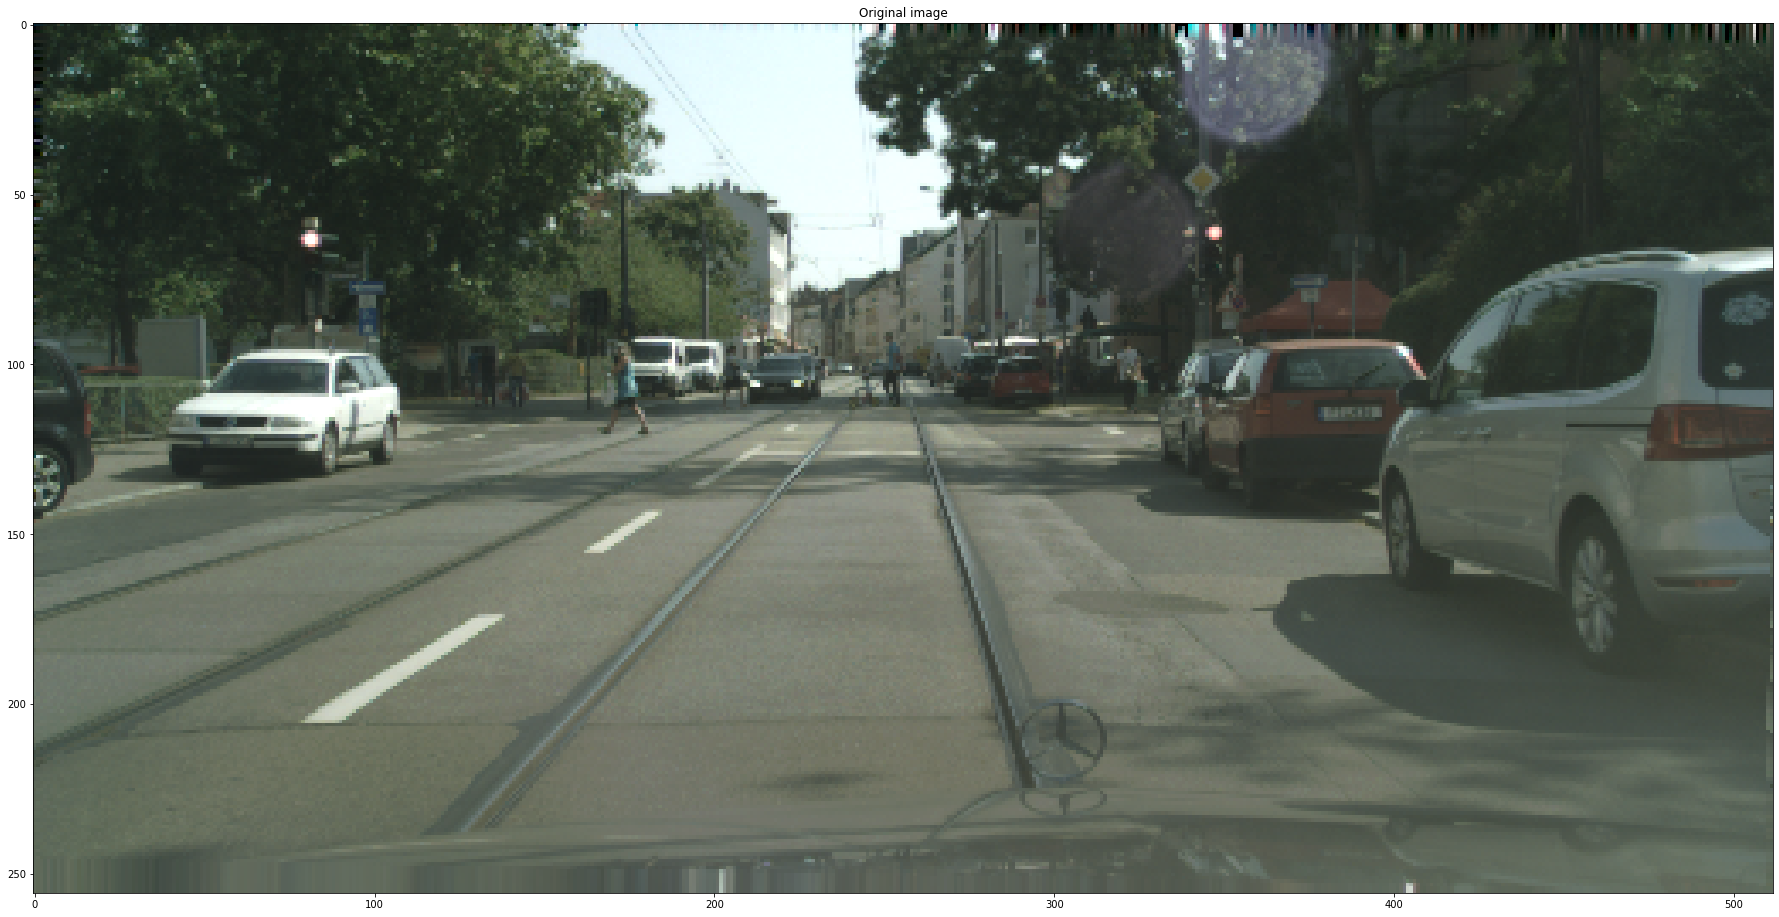

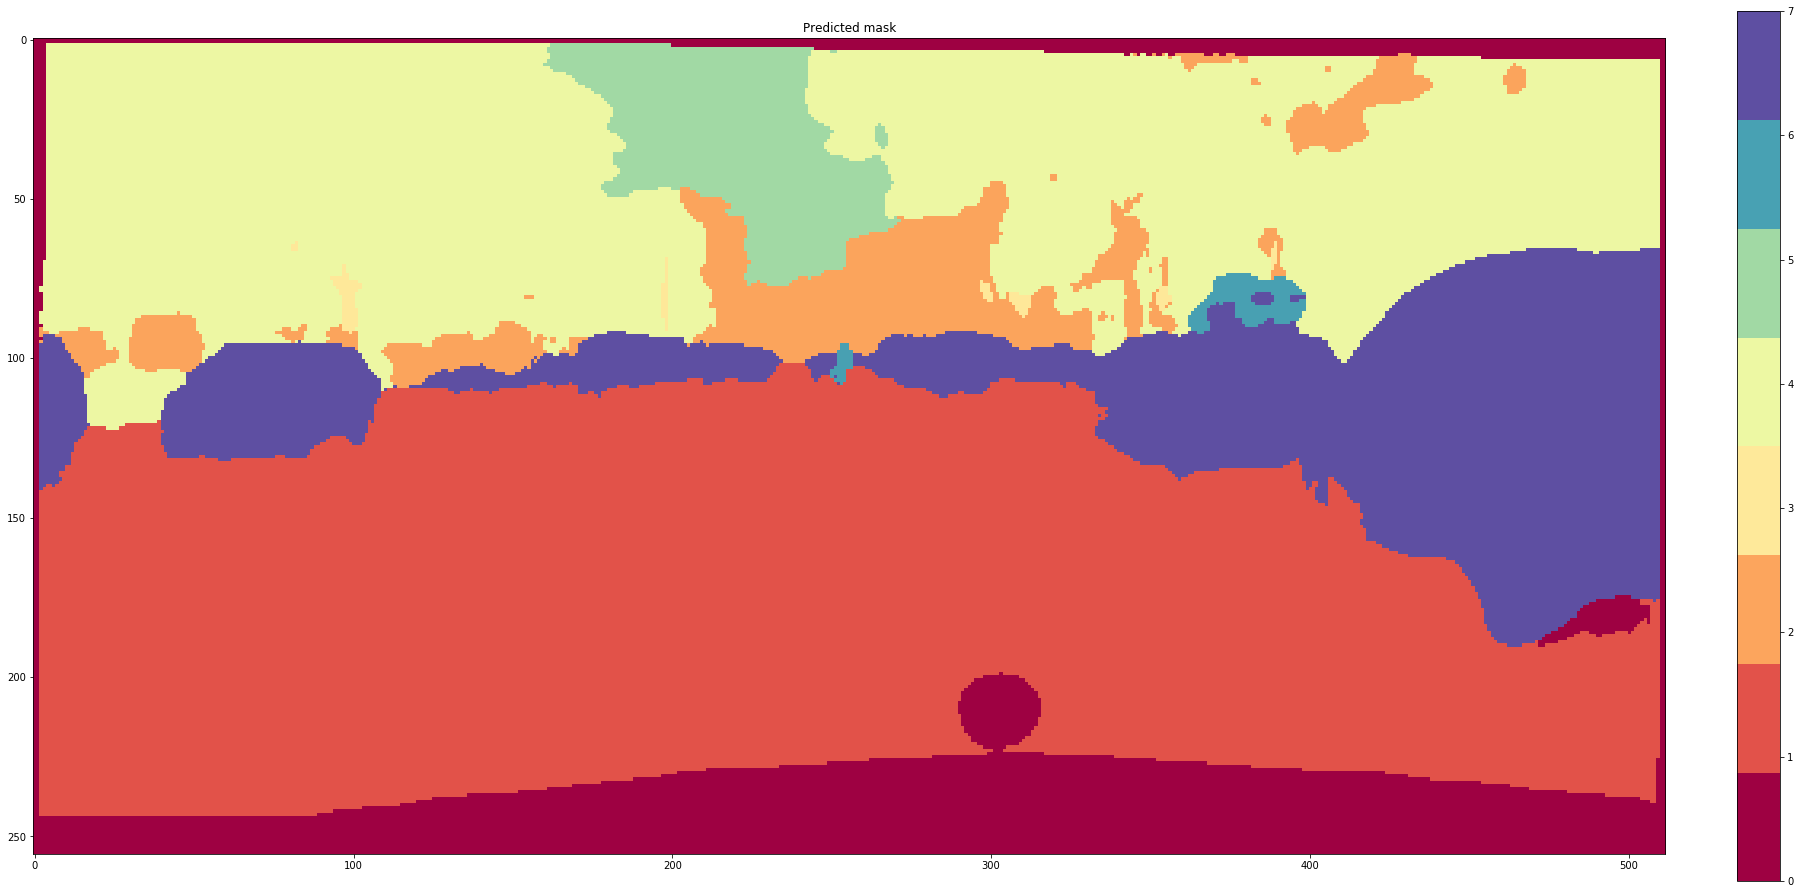

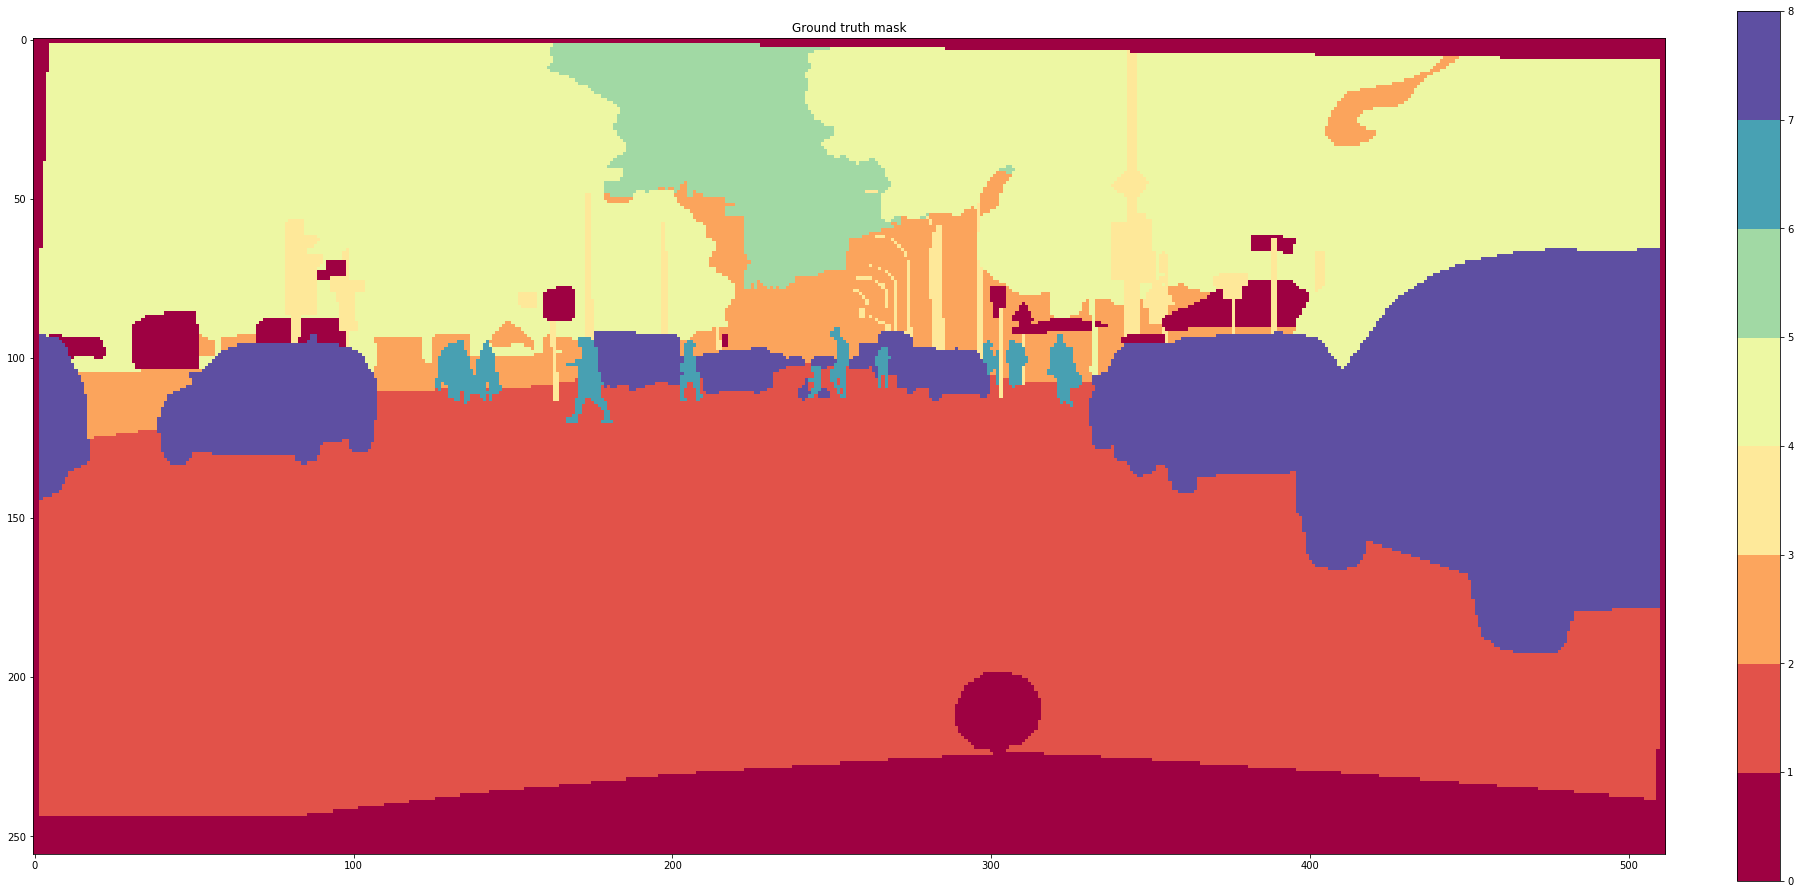

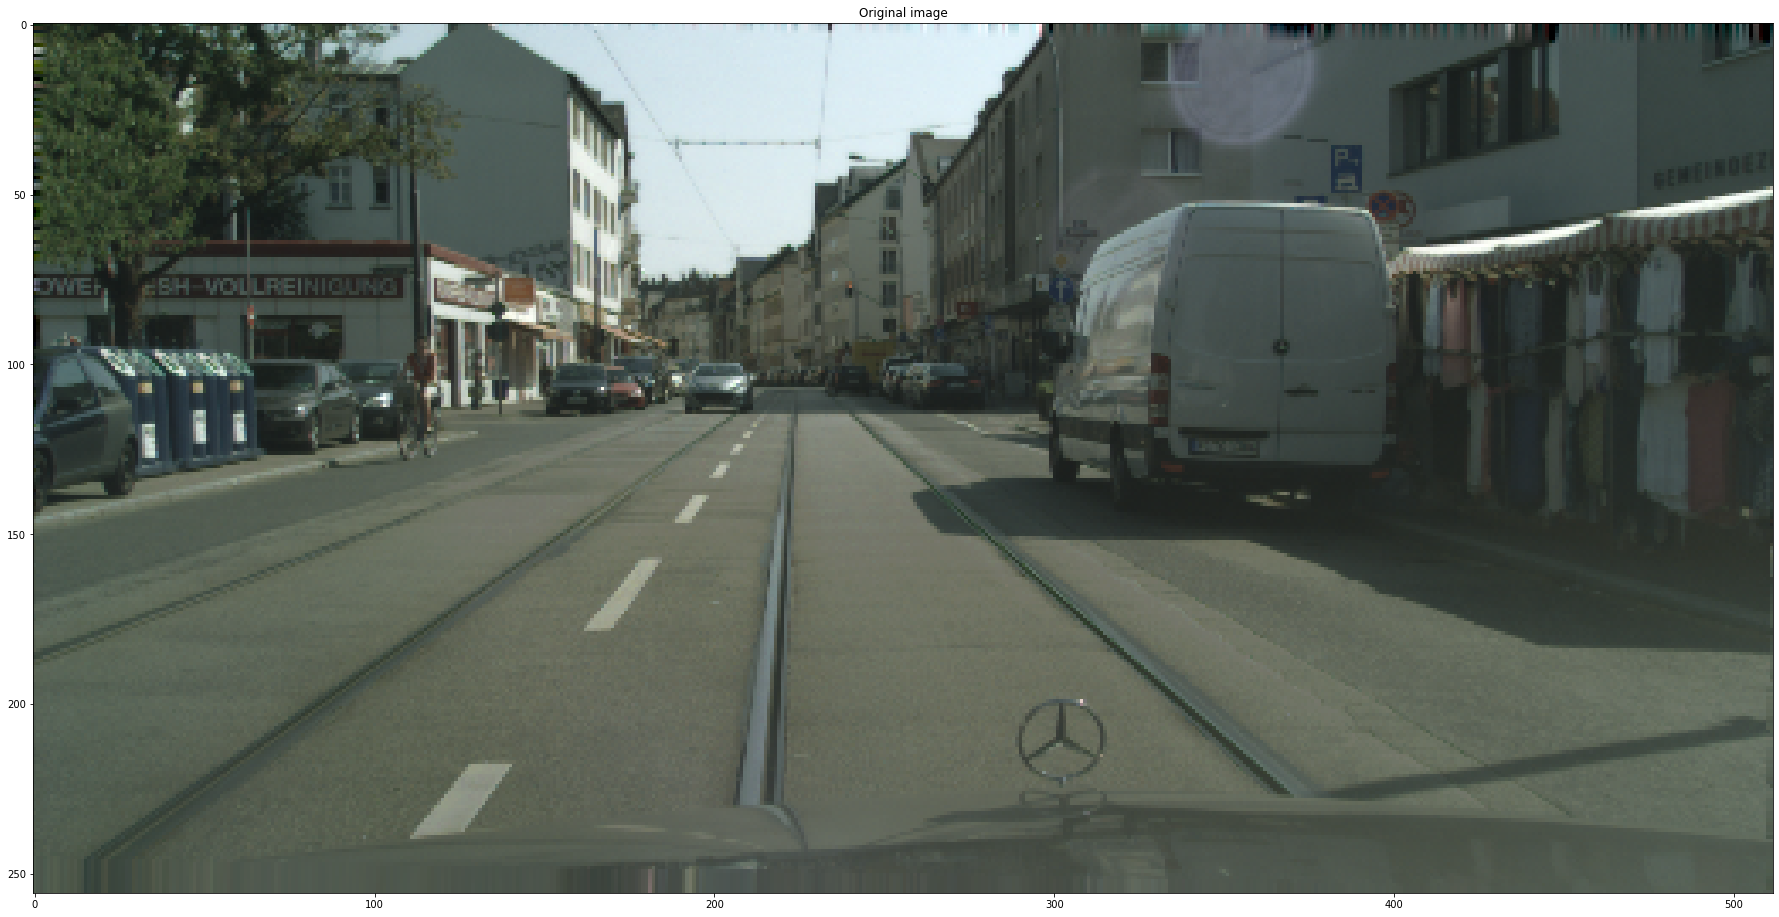

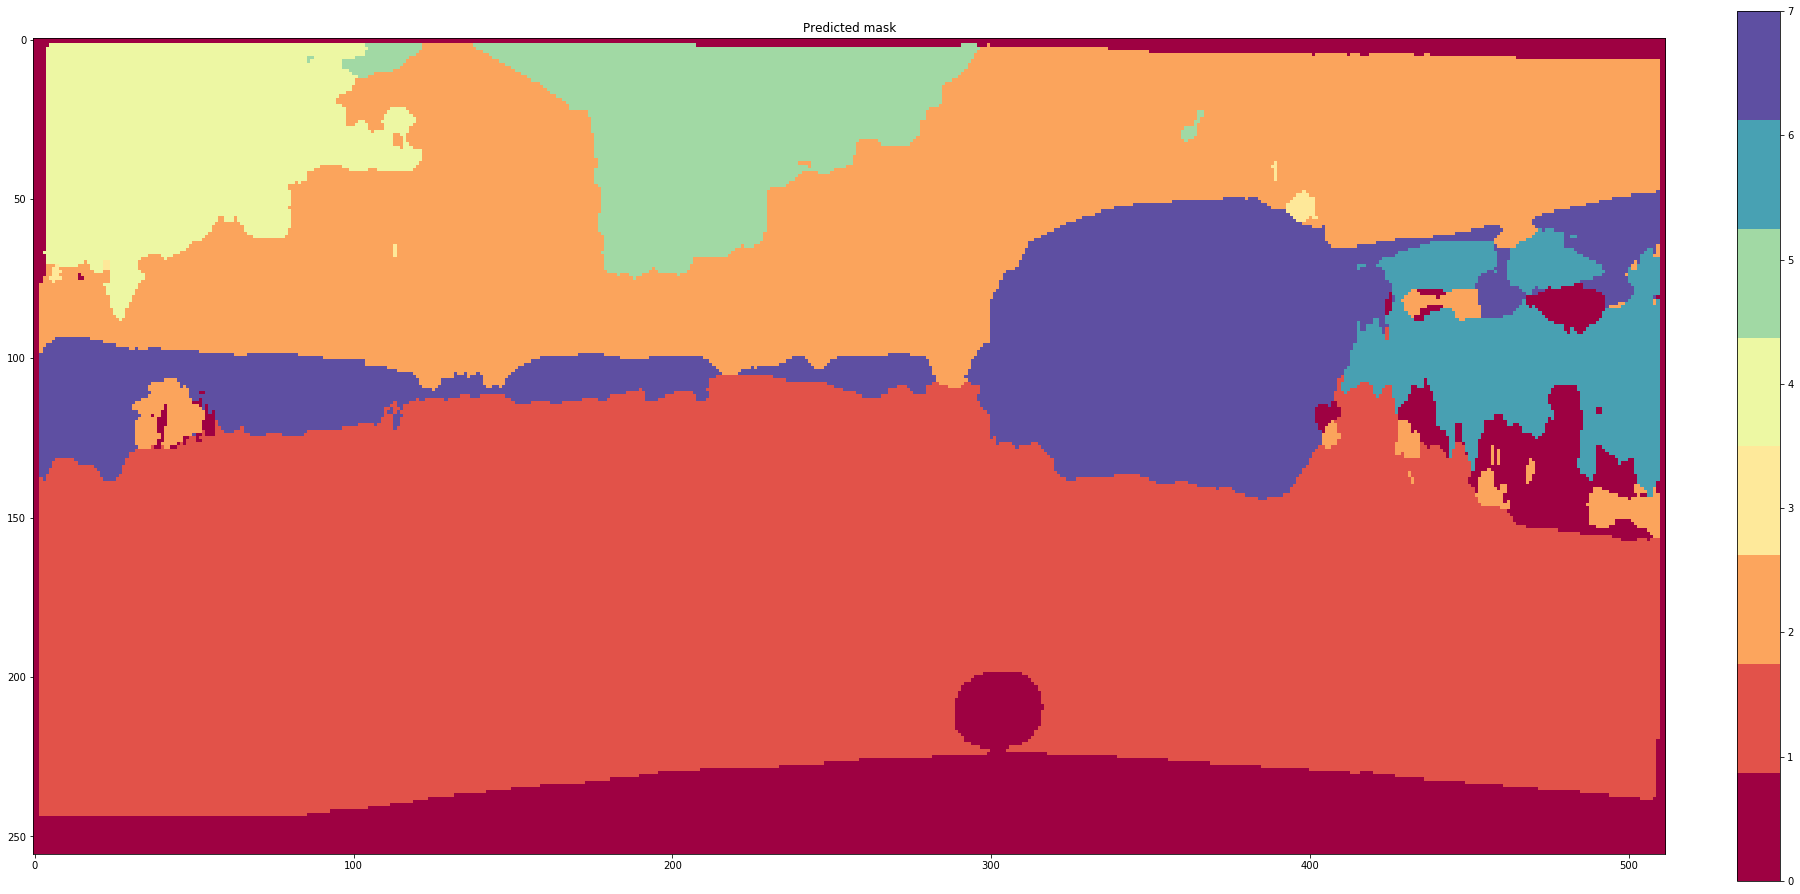

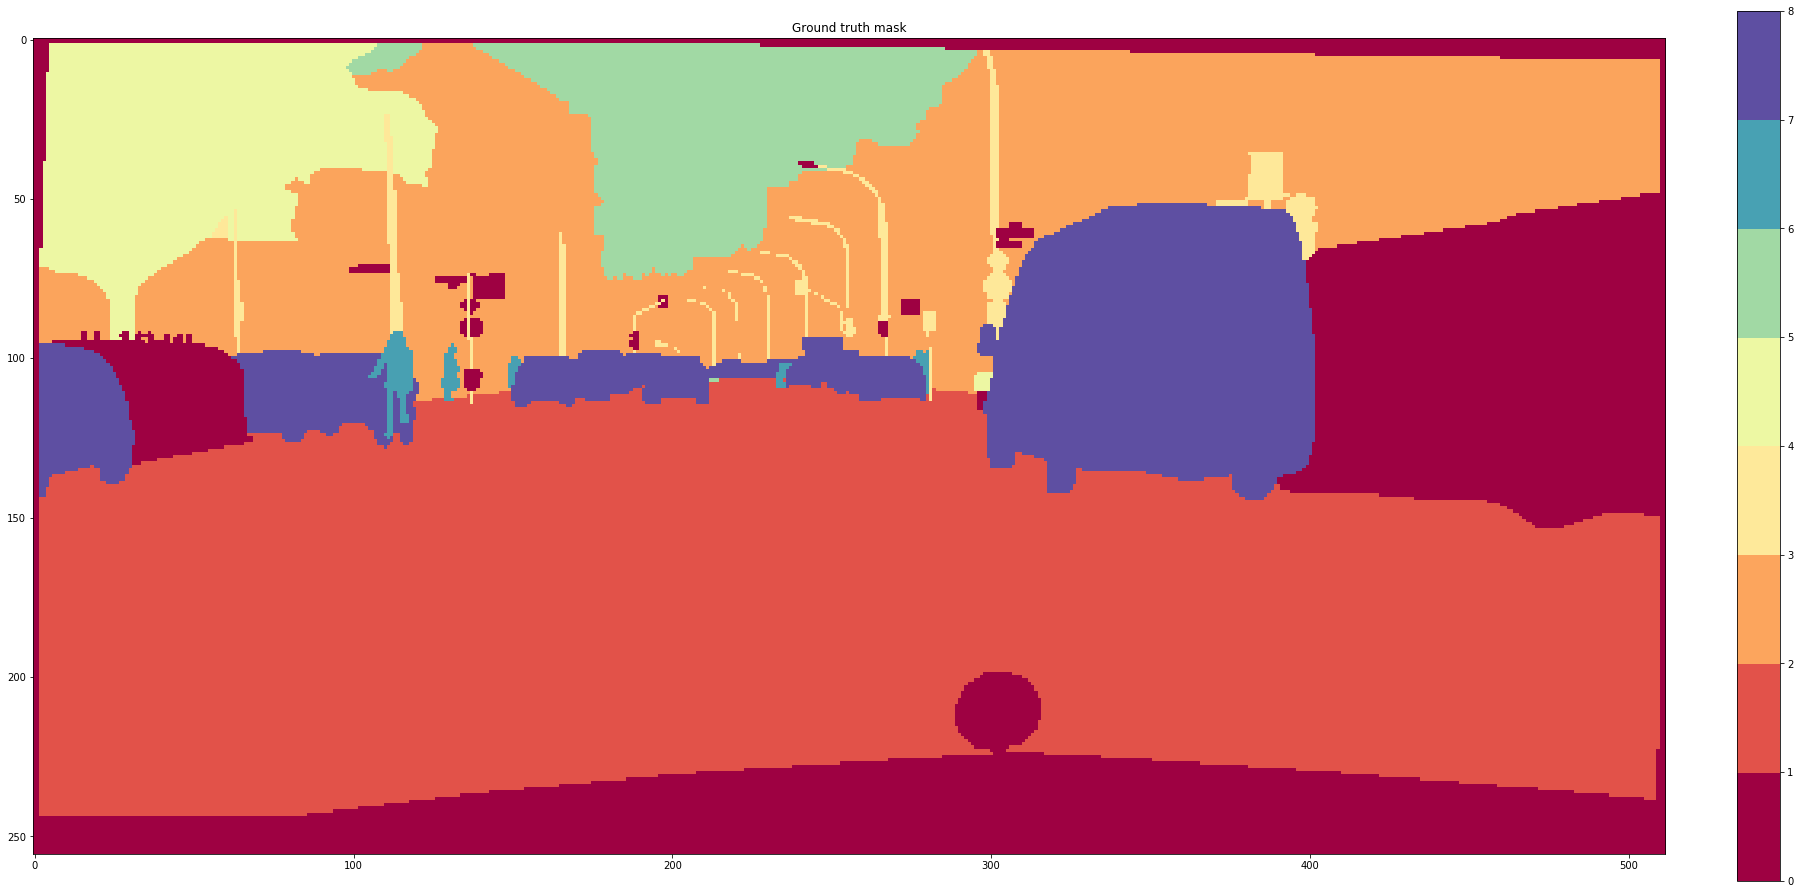

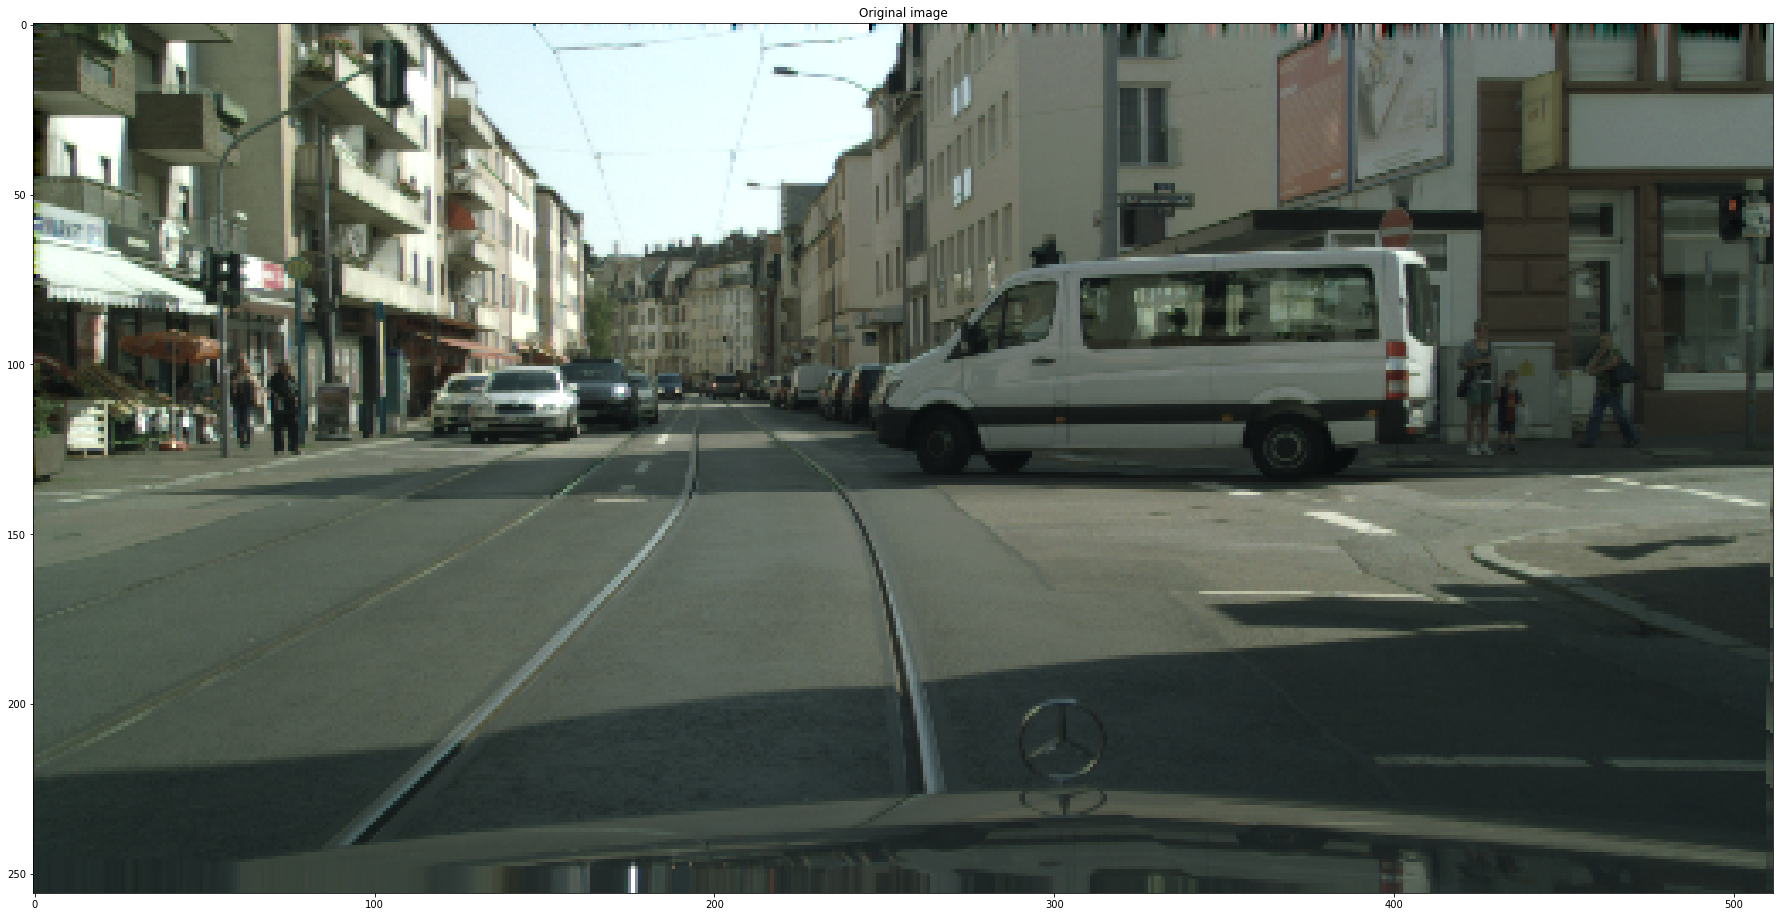

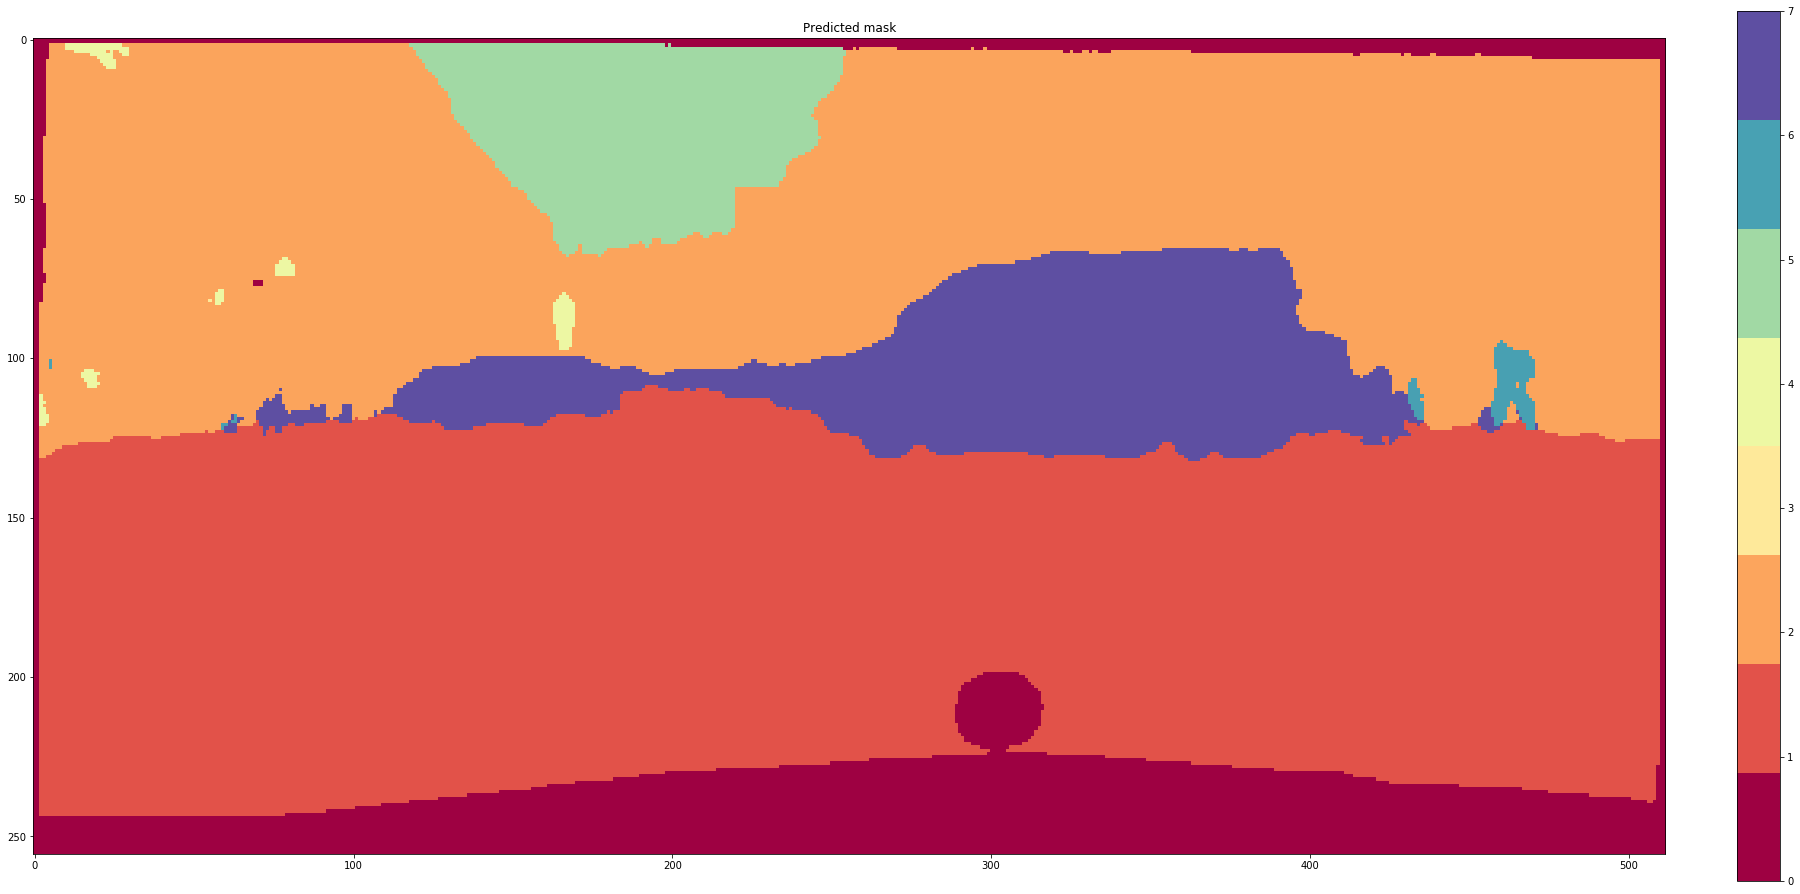

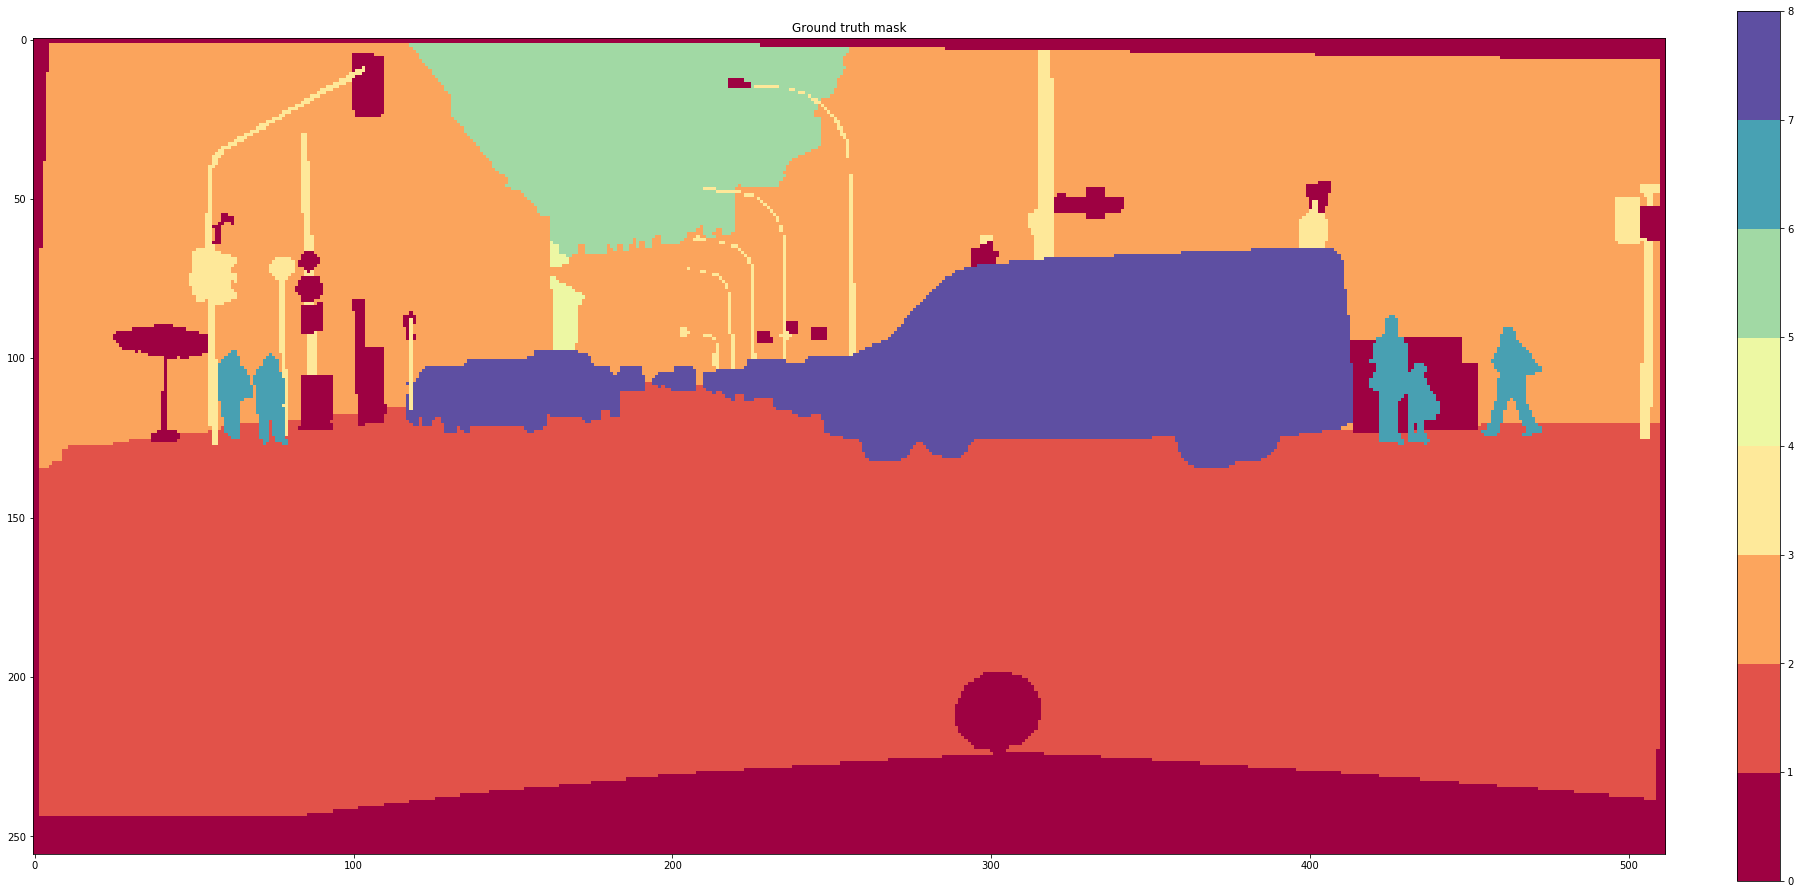

In [15]:
plot_predict_and_gt(trainunet.model, valset.X, valset.Y, range(3,6), trainparam.outfolder, trainparam.n_classes)

# 3. Seg-Grad-CAM

## 3.1 Set up layers for propagation of gradients

In [25]:
b_necks = trainunet.findBottleneck()
prop_from_layer = trainunet.model.layers[-1].name
prop_to_layer = b_necks[0]
# We recommend to try also:
#prop_to_layer = b_necks[1]

activations in b-neck:  47 , 48


## 3.2 Choose an image

In [26]:
cls = 7 # car
imid = 3
image =  valset.X[imid]

## 3.3 A. Seg-Grad-CAM for a pixel

Shape of RoI:  (256, 512)
Lengths of i and j index lists: 15960 15960


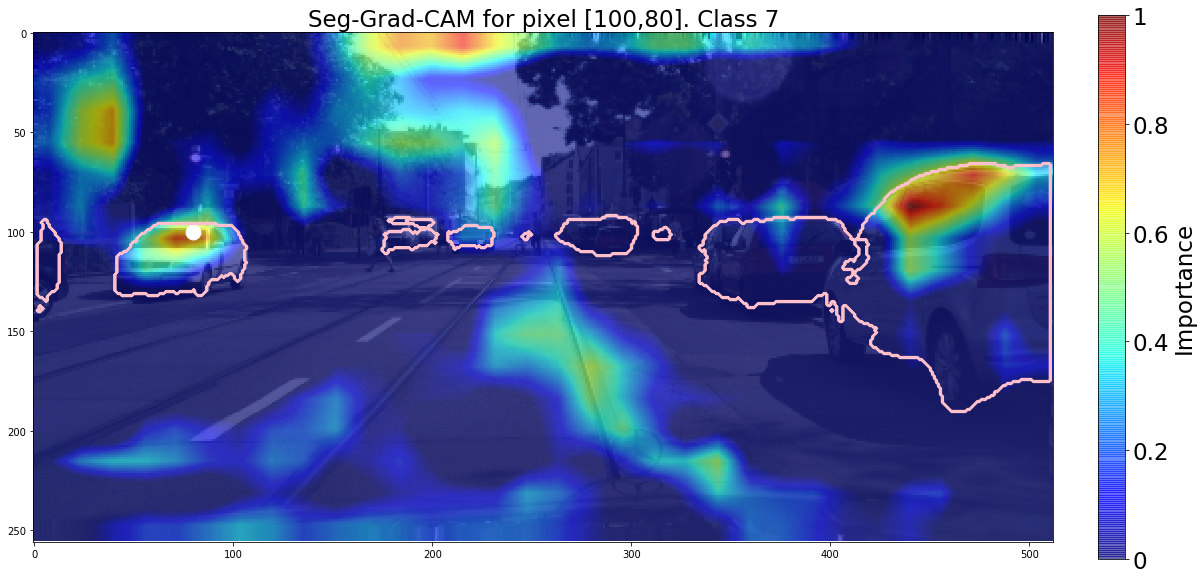

In [28]:
# ROI is a pixel in this experiment
roi=PixelRoI(100,80,image)
# create a SegGradCAM object
pixsgc = SegGradCAM(trainunet.model, image, cls,  prop_to_layer,prop_from_layer, roi=roi,
                 normalize=True, abs_w=False, posit_w=False)
# compute SegGradCAM
pixsgc.SGC()
# create an object with plotting functionality
plotter = SegGradCAMplot(pixsgc,trainunet, gt = trainset.Y[imid])
# plot explanations on 1 picture
plotter.explainPixel()

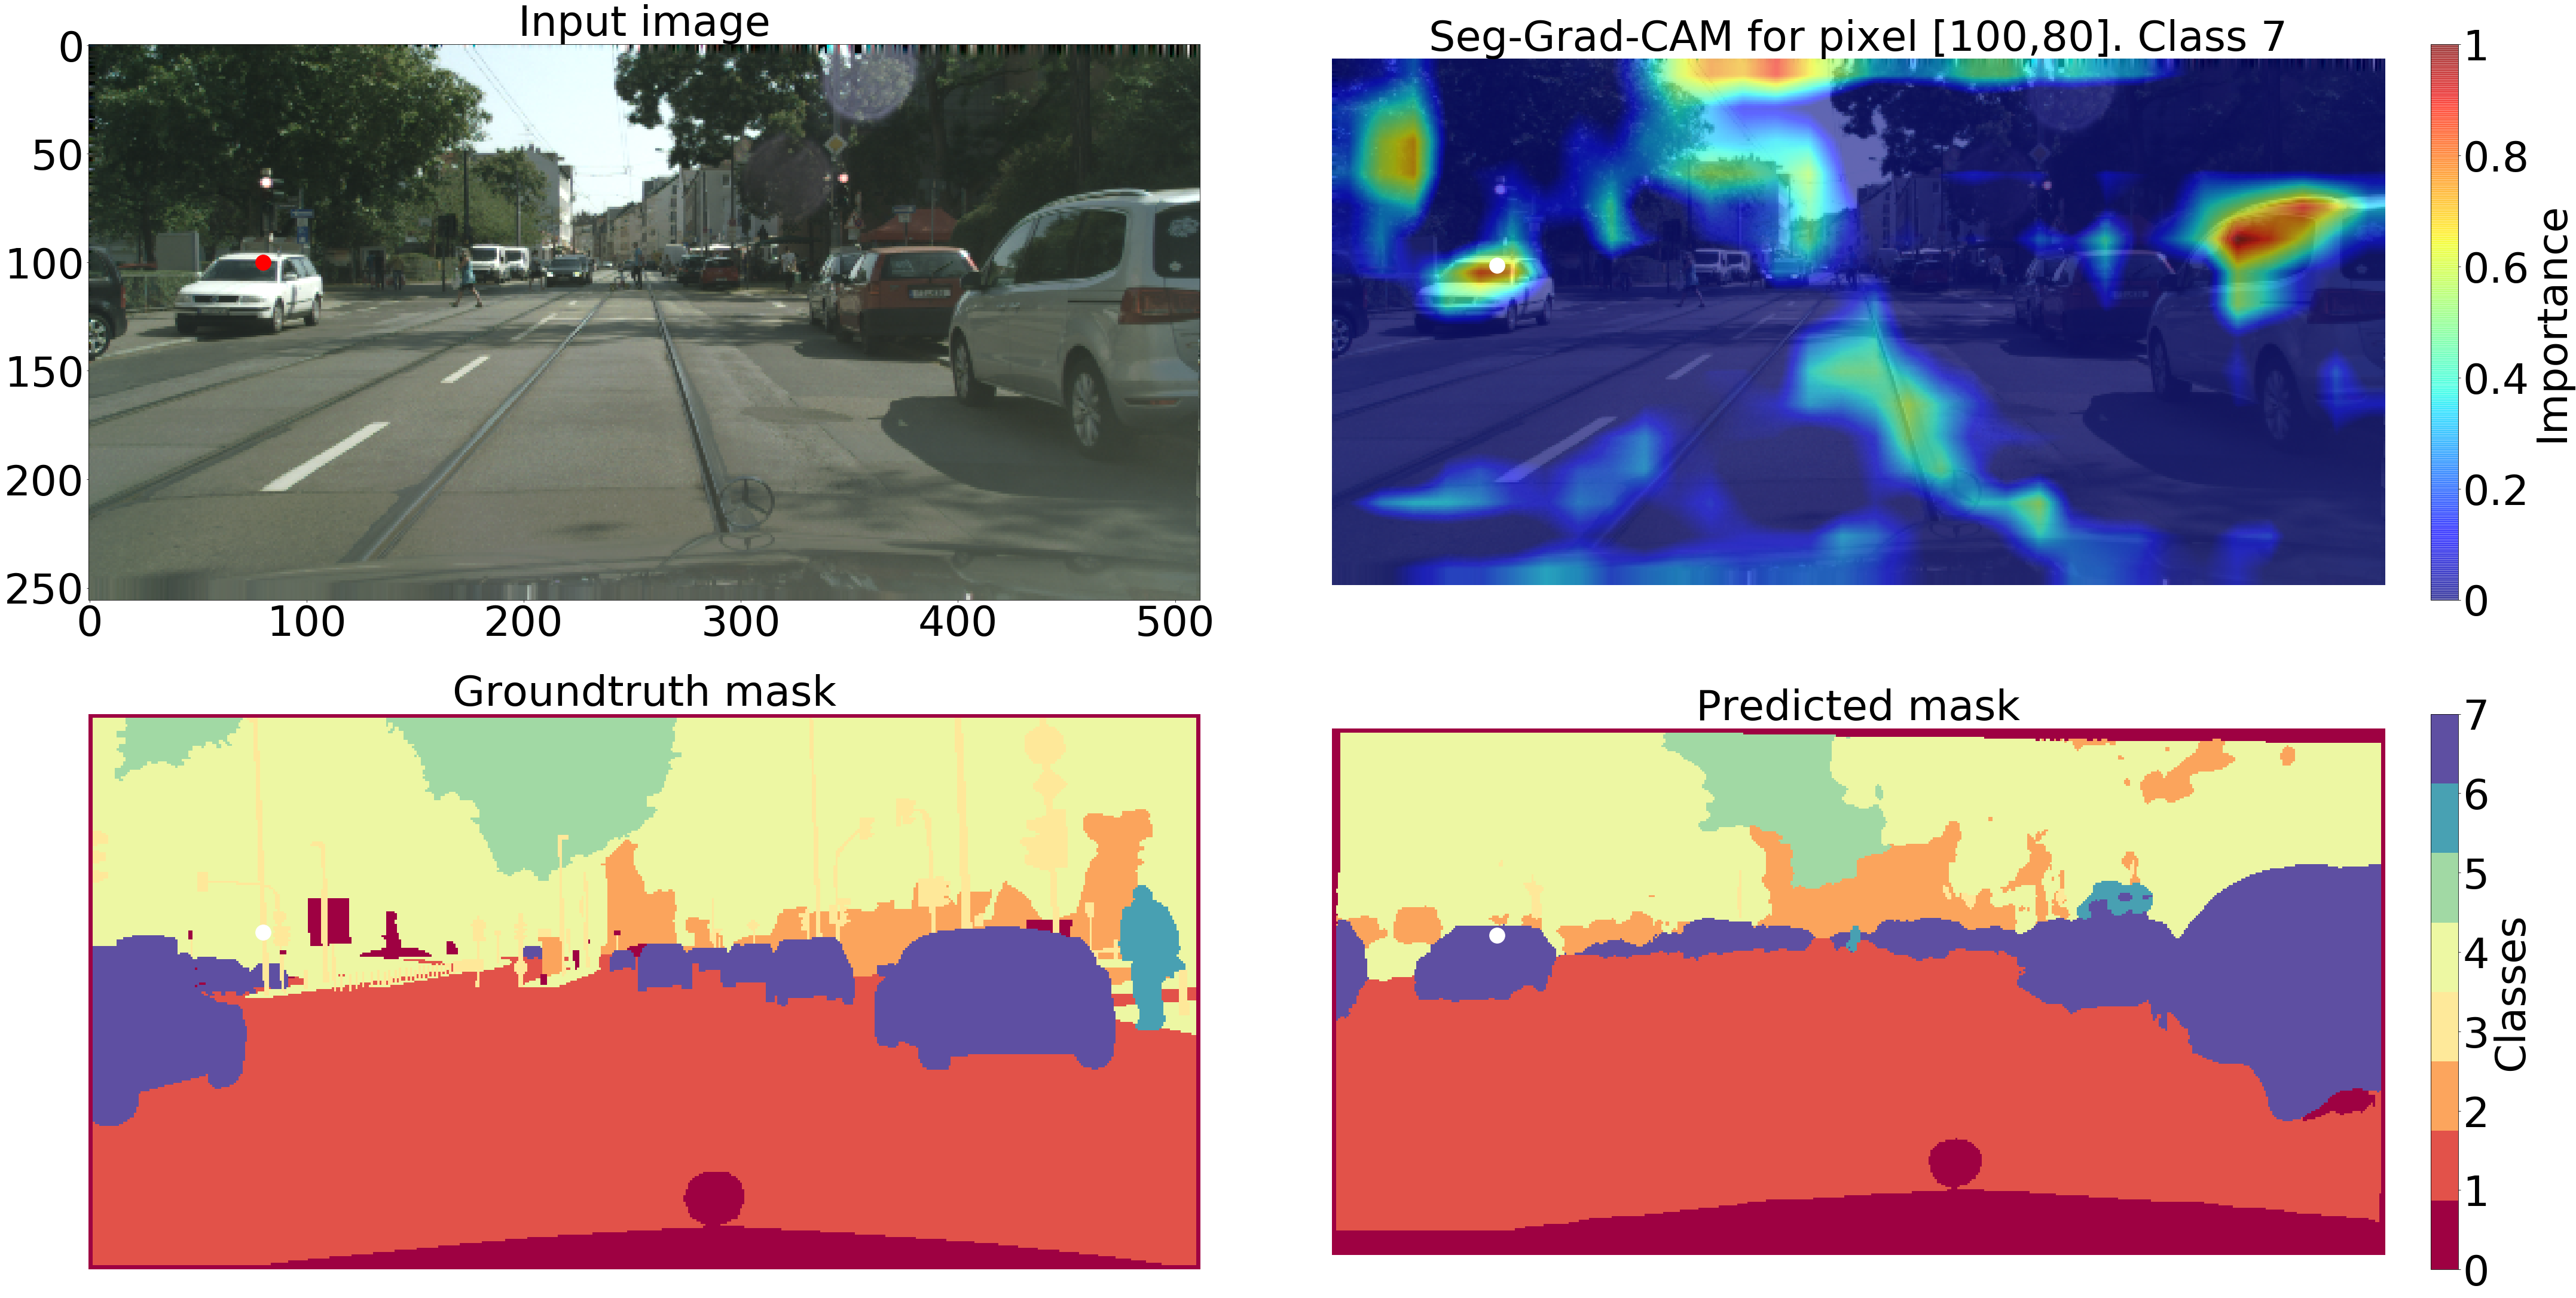

In [29]:
#Plot 4 images: original, ground truth, predicted mask, seg-grad-cam explanations for a selected single pixel
plotter.pixelGtPrediction()

## 3.3 B. Seg-Grad-CAM for the class (all pixels that were predicted as class 'cls')

Shape of RoI:  (256, 512)
Lengths of i and j index lists: 15960 15960


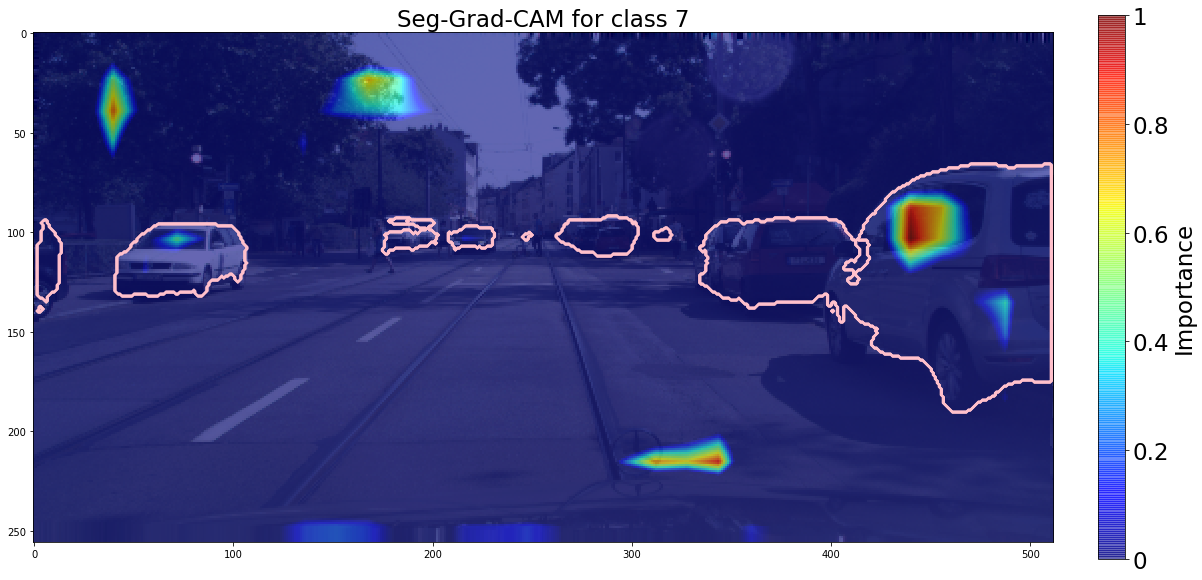

In [30]:
clsroi = ClassRoI(trainunet.model,image,cls)
clssgc = SegGradCAM(trainunet.model, image, cls,  prop_to_layer,prop_from_layer, roi=clsroi,
                 normalize=True, abs_w=False, posit_w=False)
clssgc.SGC()
clsplotter = SegGradCAMplot(clssgc,trainunet, gt=trainset.Y[imid])
clsplotter.explainClass()

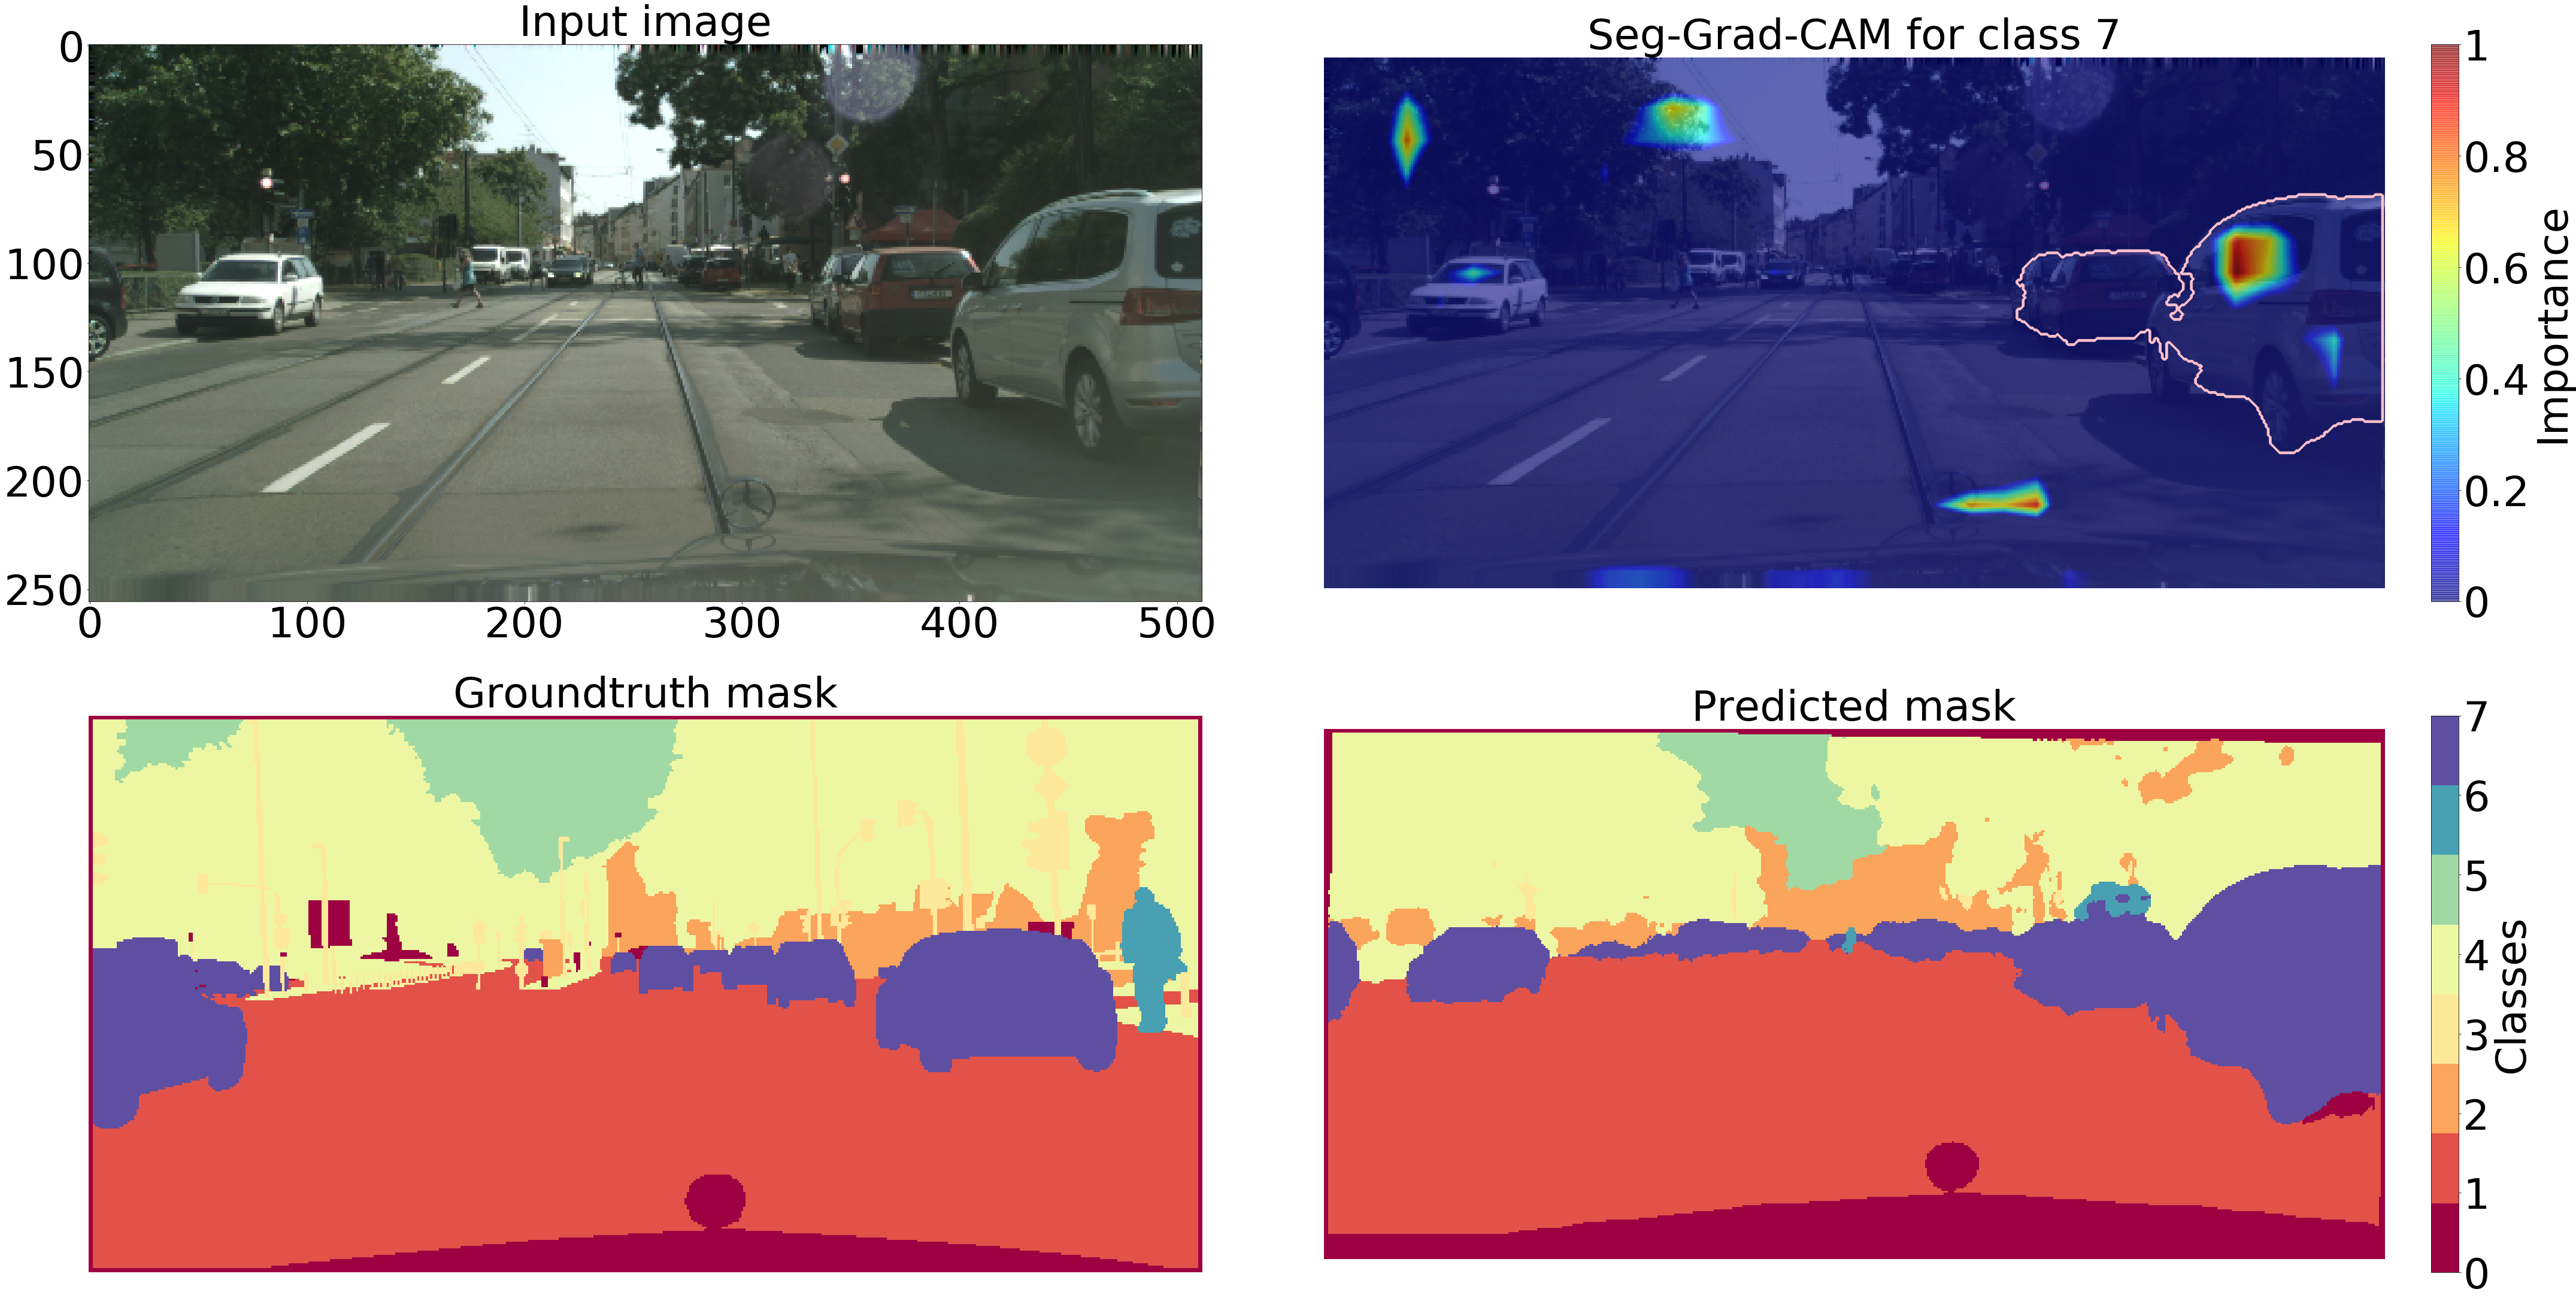

In [38]:
clsplotter.classGtPrediction()

## 3.3 C. Seg-Grad-CAM for a region of interest
### 3.3.C.1 for the largest set of connected pixels predicted as 'cls'

Shape of RoI:  (256, 512)
Lengths of i and j index lists: 15960 15960
connectedComponents values, counts:  [ 0  1  2  3  4  5  6  7  8  9 10] [115112  12579    602    274    356   1895    199     39     10      5
      1]
argmax:  1
Shape of RoI:  (256, 512)
Lengths of i and j index lists: 12579 12579


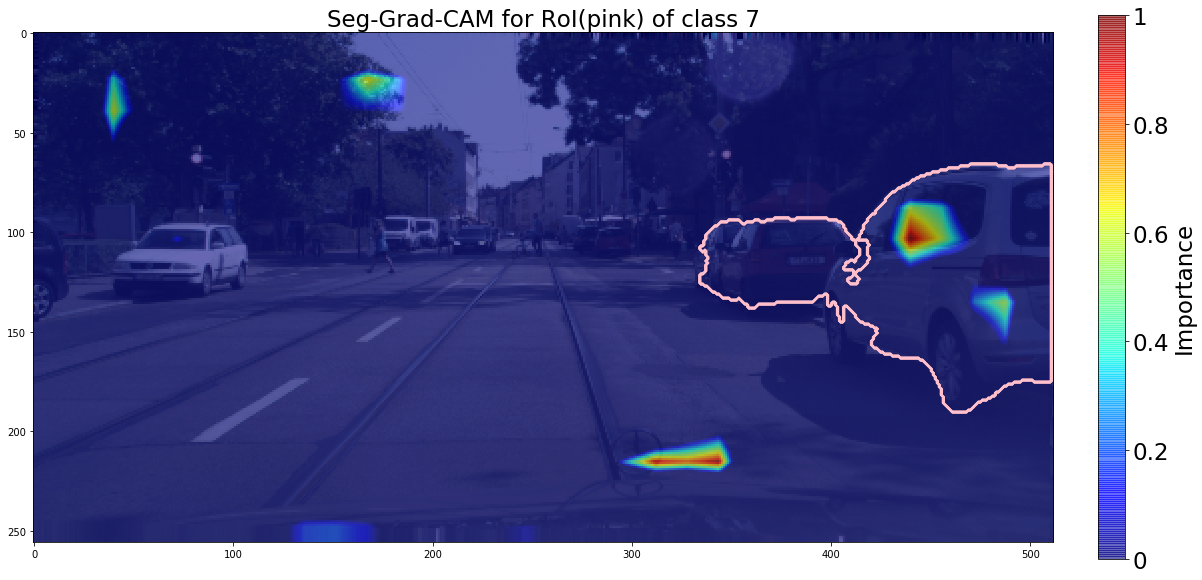

In [34]:
largeroi = ClassRoI(trainunet.model,image,cls)
# find the largest connected component of pixels predicted as 'cls'
largeroi.largestComponent()

largesgc = SegGradCAM(trainunet.model, image, cls,  prop_to_layer,prop_from_layer, roi=largeroi,
                 normalize=True, abs_w=False, posit_w=False)
largesgc.SGC()
roiplotter = SegGradCAMplot(largesgc,trainunet,gt=trainset.Y[imid])
roiplotter.explainRoi()

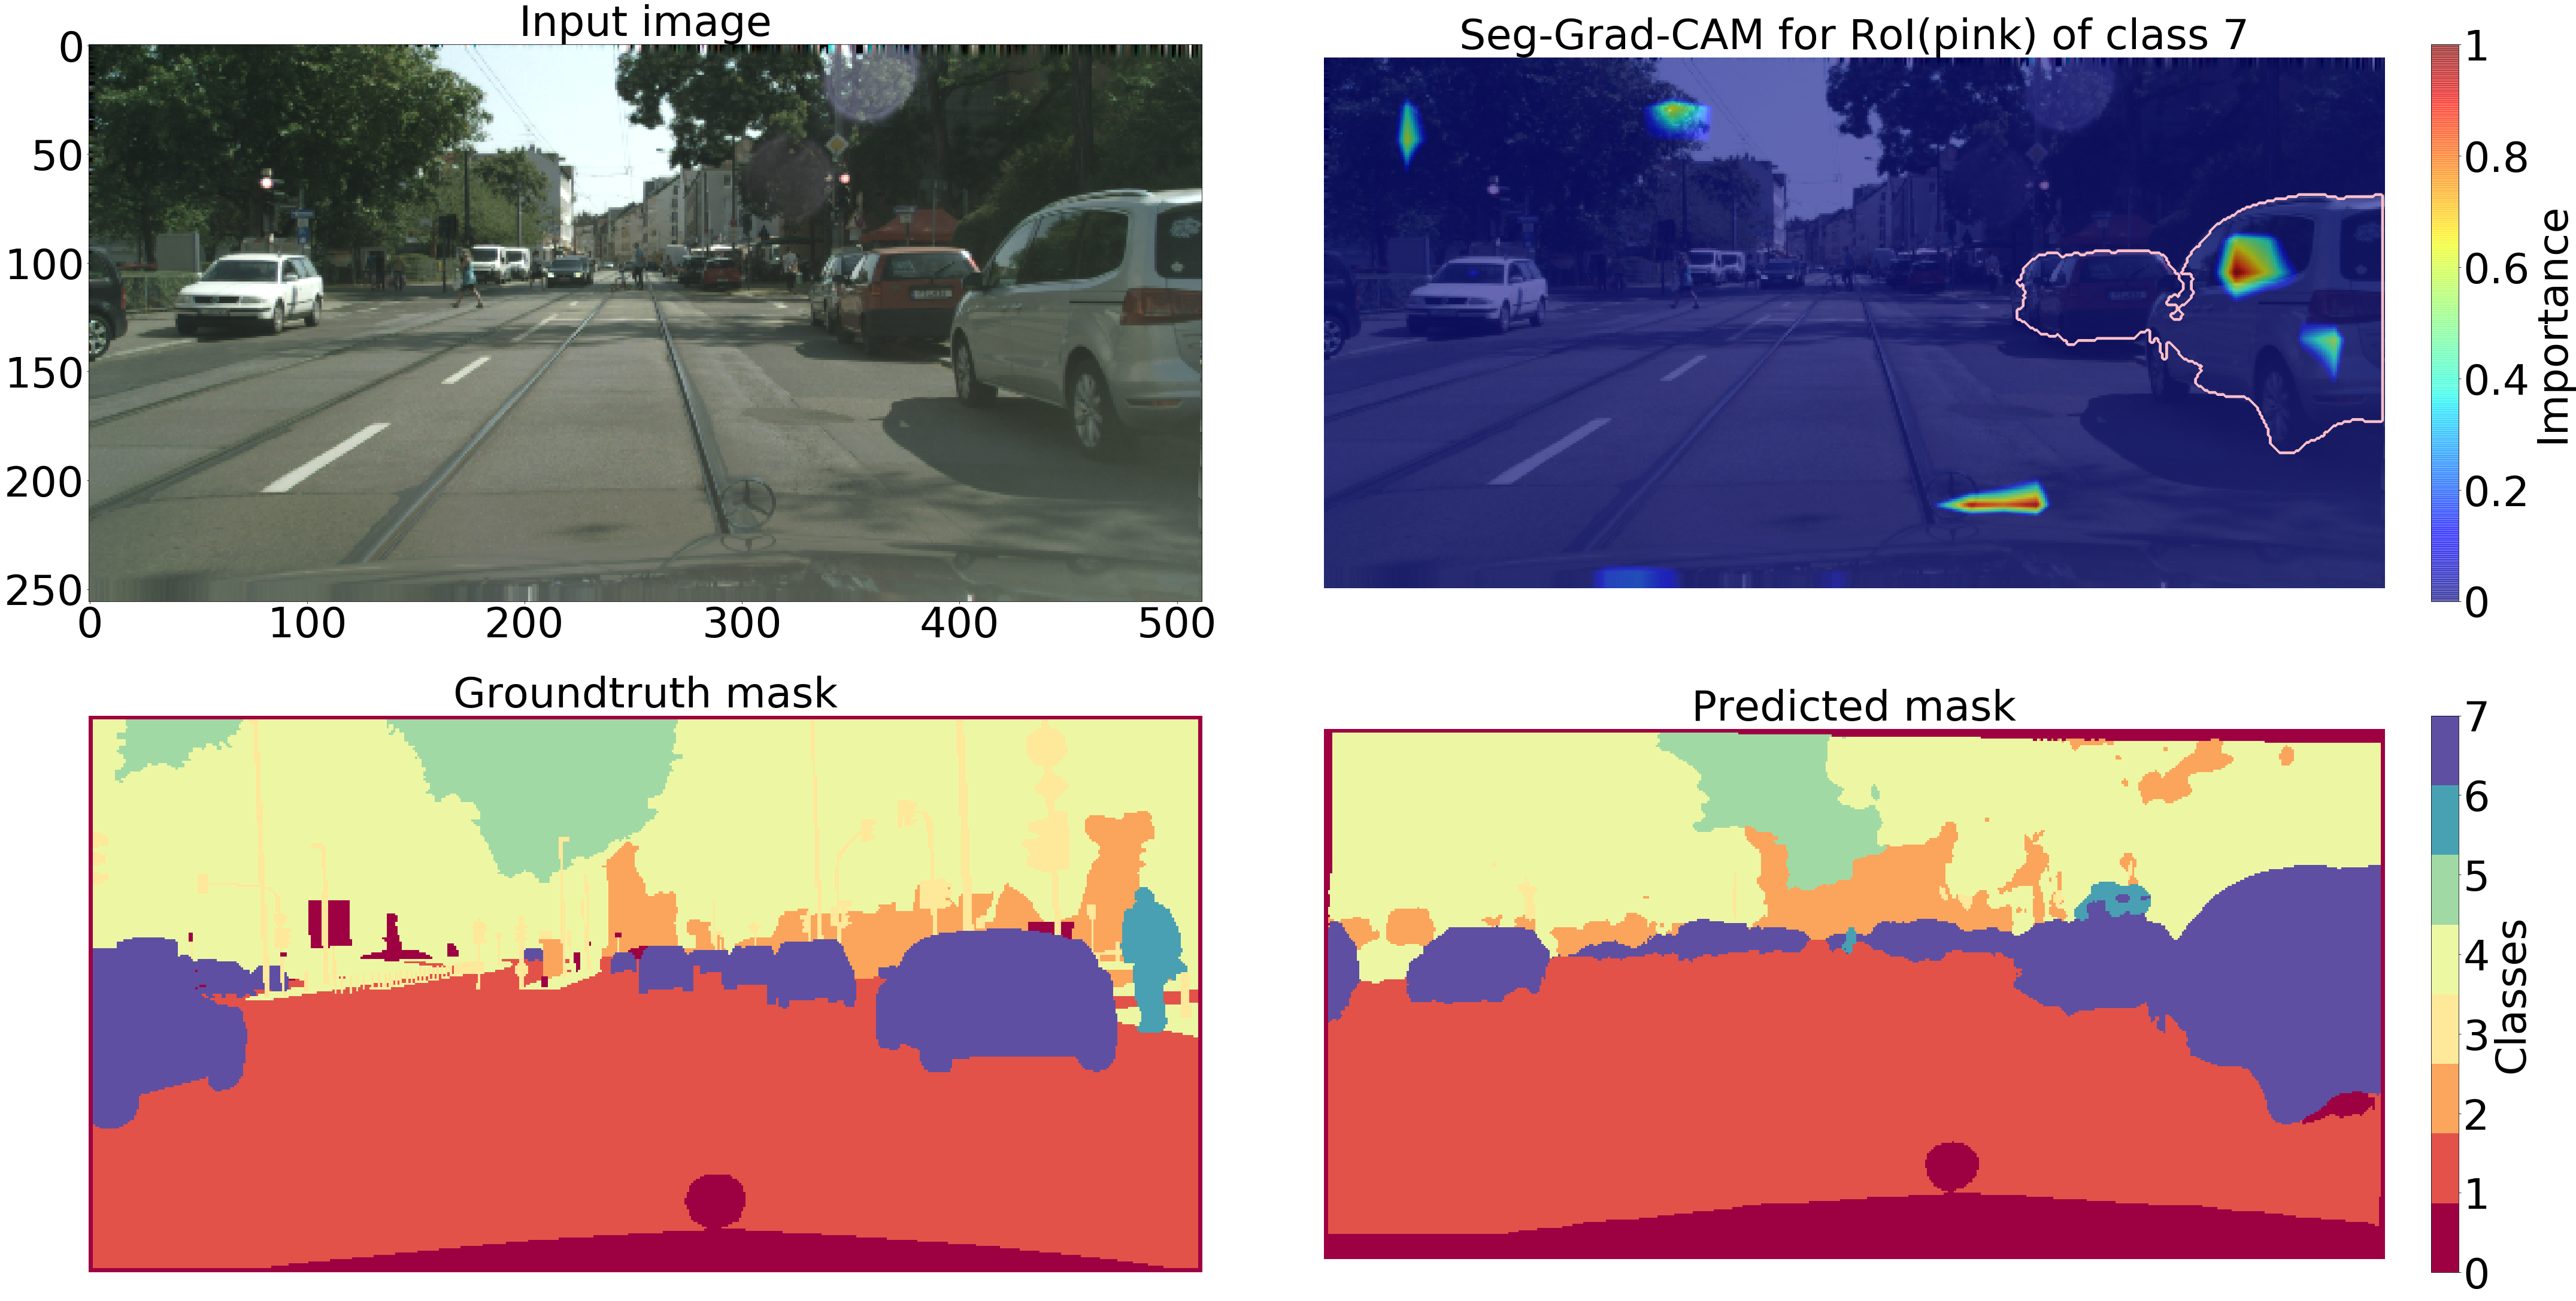

In [39]:
roiplotter.roiGtPrediction()

### 3.3.C.2 for the smallest set of connected pixels predicted as 'cls'

Shape of RoI:  (256, 512)
Lengths of i and j index lists: 15960 15960
connectedComponents values, counts:  [ 0  1  2  3  4  5  6  7  8  9 10] [115112  12579    602    274    356   1895    199     39     10      5
      1]
argmin:  10
Shape of RoI:  (256, 512)
Lengths of i and j index lists: 1 1


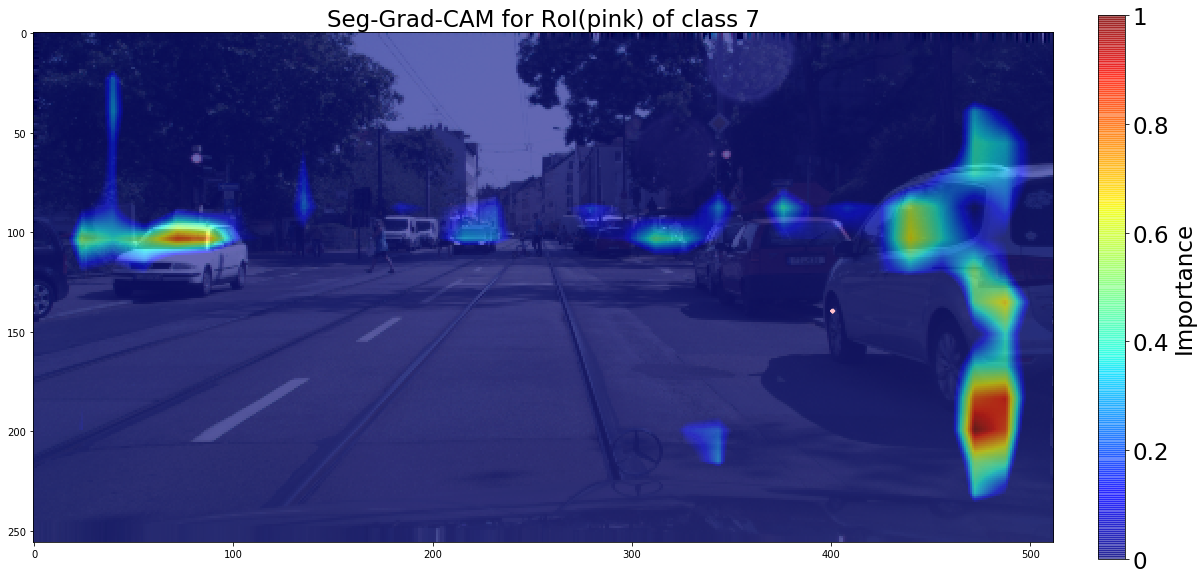

In [36]:
smallroi = ClassRoI(trainunet.model,image,cls)
# Now, for the smallest component
smallroi.smallestComponent()

smallsgc = SegGradCAM(trainunet.model, image, cls,  prop_to_layer,prop_from_layer, roi=smallroi,
                 normalize=True, abs_w=False, posit_w=False)
smallsgc.SGC()
smallroiplotter = SegGradCAMplot(smallsgc,trainunet,gt=trainset.Y[imid])
smallroiplotter.explainRoi()

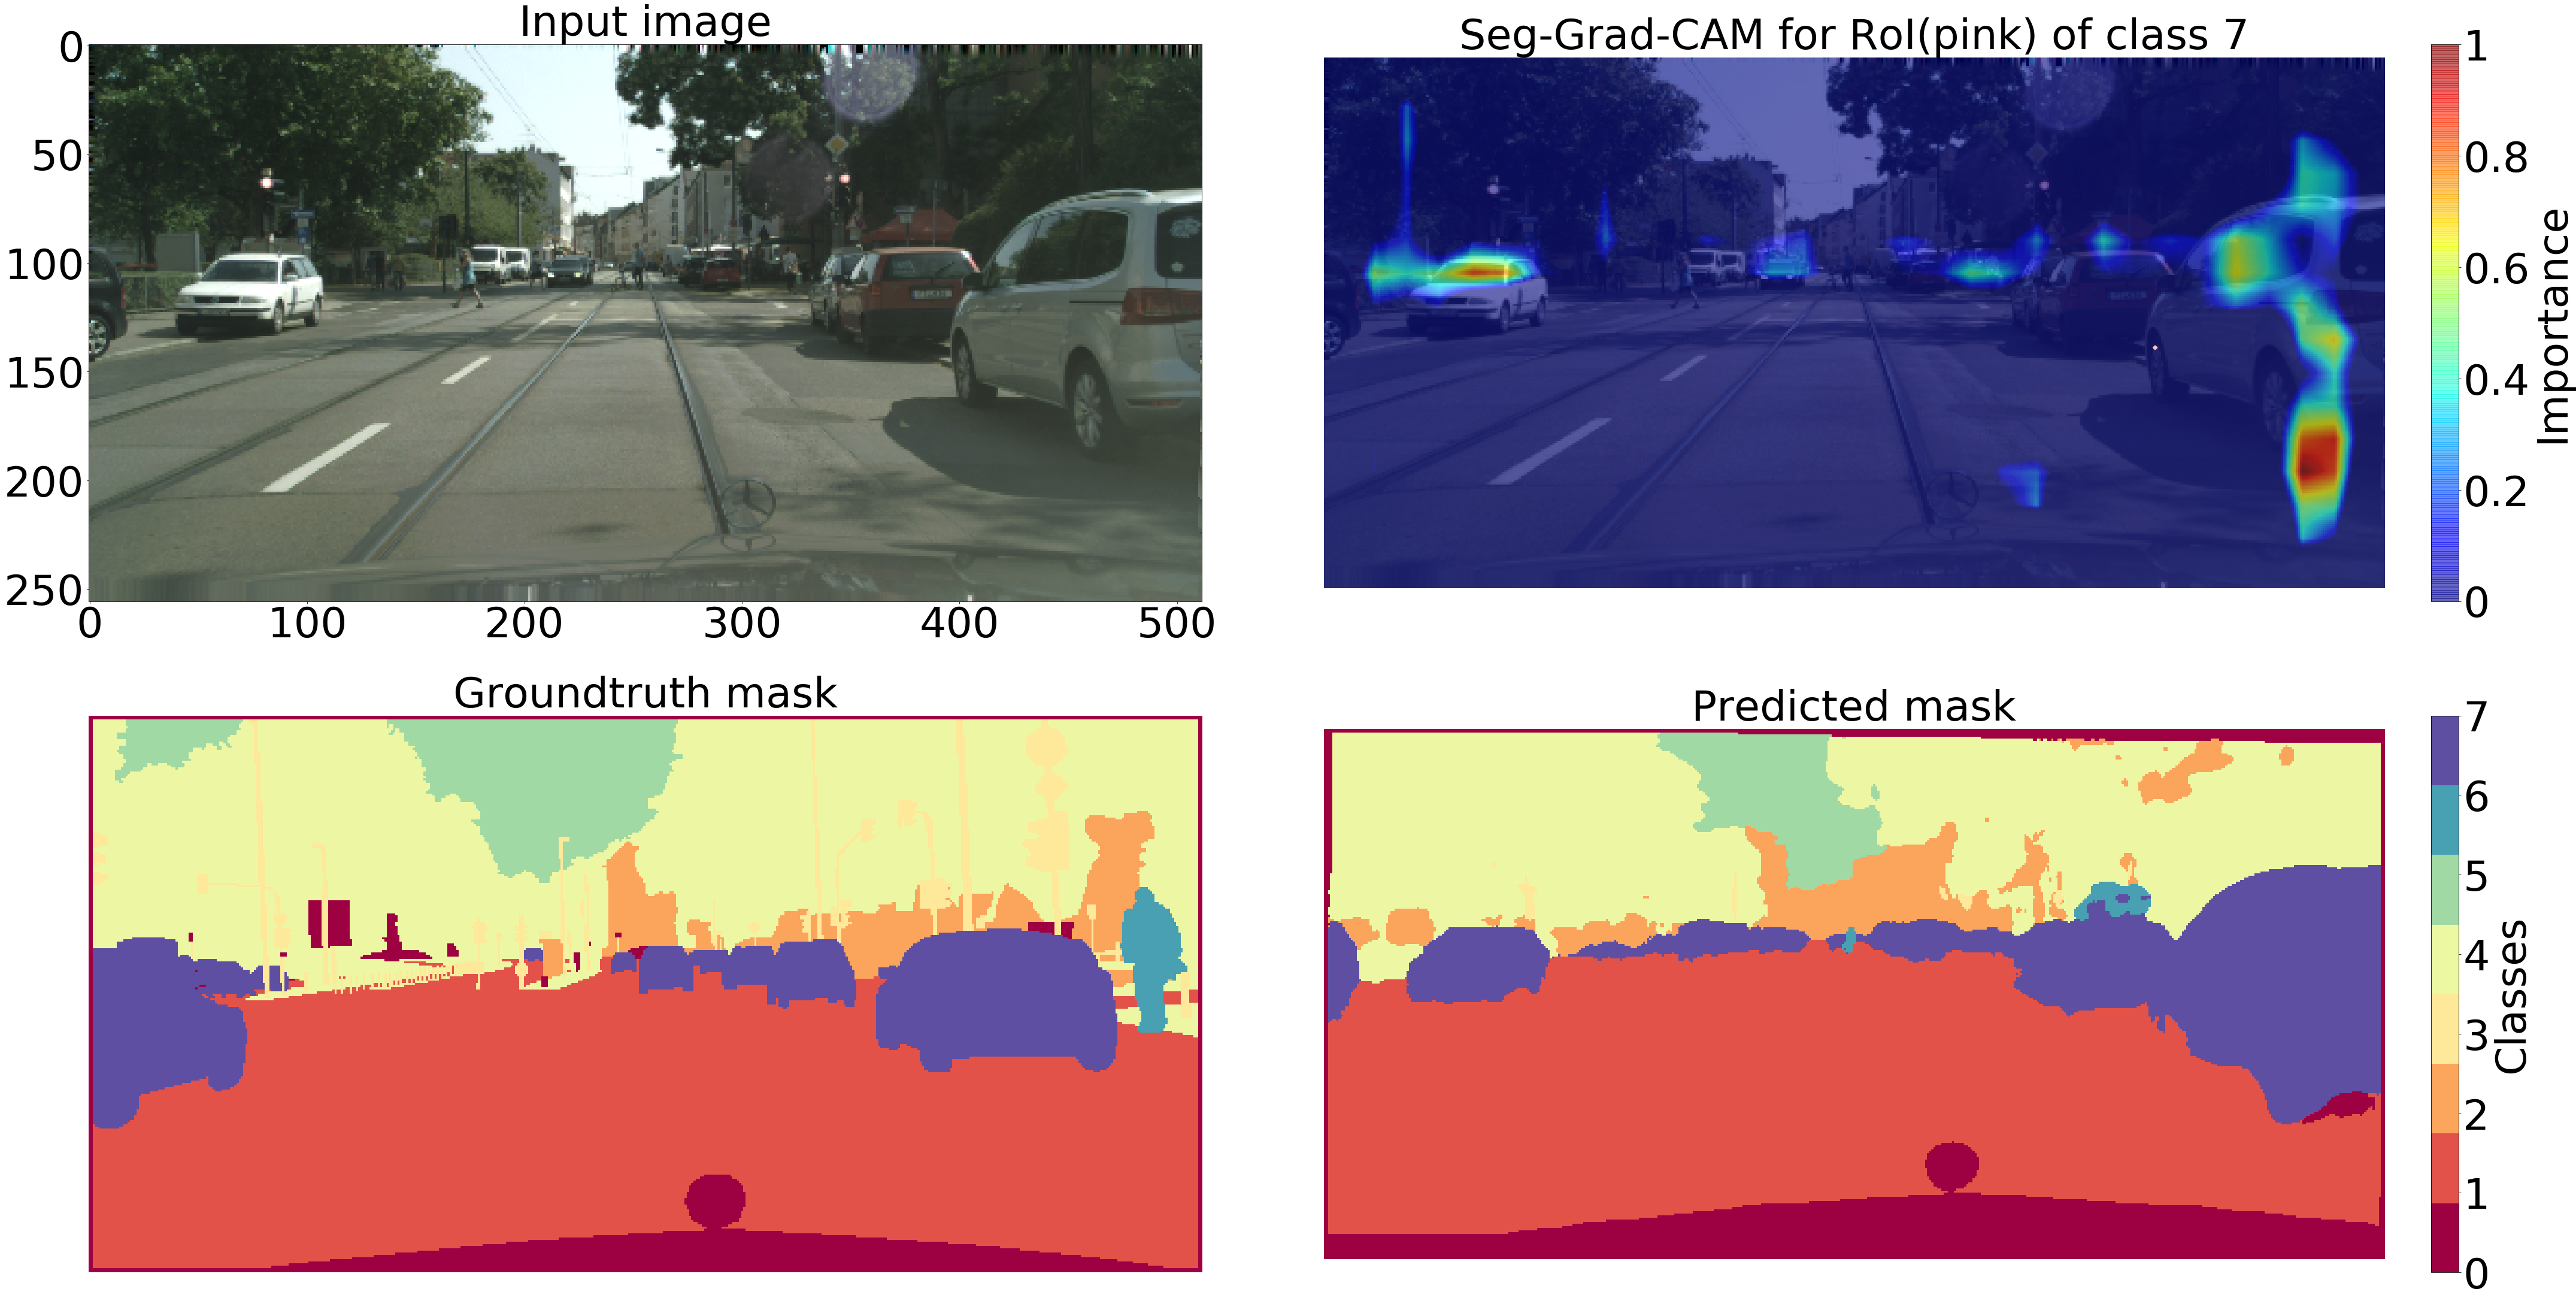

In [40]:
smallroiplotter.roiGtPrediction()

### 3.3.C.3 It is also possible to define an arbitrary RoI